<a href="https://colab.research.google.com/github/chellick/Super_resolution/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import time

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [ ]:
train_images.shape

(50000, 32, 32, 3)

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(100)

In [ ]:
generator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2048, input_shape=(100,)),
    tf.keras.layers.Reshape((2, 2, 512)),
    tf.keras.layers.Conv2DTranspose(256, (5, 5,), strides=(2), padding='same'),
    tf.keras.layers.Conv2DTranspose(128, (5, 5,), strides=(2), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, (5, 5,), strides=(2), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(3, (5, 5,), strides=(2), padding='same', activation='tanh'),

])

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              206848    
                                                                 
 reshape (Reshape)           (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        3277056   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 128)        819328    
 ranspose)                                                       
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 128)        512       
 ormalization)                                                   
                                                        

In [ ]:
discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(3, input_shape=[32, 32, 3]),
    tf.keras.layers.Conv2D(64, (5, 5), strides=(2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(128, (5, 5), strides=(2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(256, (5, 5), strides=(2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(512, (5, 5), strides=(2), padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32, 32, 3)         12        
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         819456    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 256)        

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

Loss \ train definition

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Train

In [ ]:
epochs = 30
seed = tf.random.normal([100, 100])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([100, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise)

        real_output = discriminator(images)
        fake_output = discriminator(generated_images)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



In [ ]:
for epoch in range(epochs):
    start = time.time()
    for batch in train_dataset:
        train_step(batch)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

generator.save('/content/models/generator')
discriminator.save('/content/models/discriminator')

Time for epoch 1 is 33.21180486679077 sec
Time for epoch 2 is 32.87946271896362 sec
Time for epoch 3 is 33.59705686569214 sec
Time for epoch 4 is 34.162970781326294 sec
Time for epoch 5 is 34.578983306884766 sec
Time for epoch 6 is 34.87555742263794 sec
Time for epoch 7 is 35.14008140563965 sec
Time for epoch 8 is 35.344969749450684 sec
Time for epoch 9 is 35.20082759857178 sec
Time for epoch 10 is 35.16959547996521 sec
Time for epoch 11 is 35.23787188529968 sec
Time for epoch 12 is 35.18988037109375 sec
Time for epoch 13 is 35.19250440597534 sec
Time for epoch 14 is 35.15700578689575 sec
Time for epoch 15 is 35.20305824279785 sec
Time for epoch 16 is 35.174455881118774 sec
Time for epoch 17 is 35.14554166793823 sec
Time for epoch 18 is 35.11129093170166 sec
Time for epoch 19 is 35.09941124916077 sec
Time for epoch 20 is 35.120734453201294 sec
Time for epoch 21 is 35.07215690612793 sec
Time for epoch 22 is 35.066590547561646 sec
Time for epoch 23 is 35.07510232925415 sec
Time for epoch

Time for epoch 100 is 34.807111501693726 sec


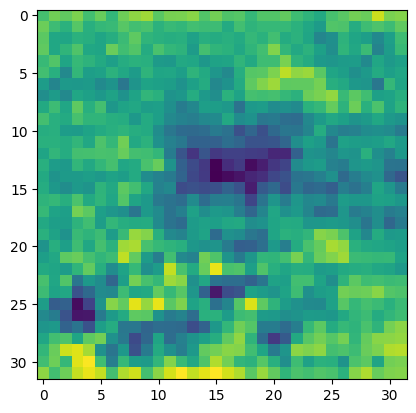

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)


plt.imshow(generated_image[0, :, :, 0], )

In [ ]:
discriminator(generated_image) > 0

<tf.Tensor: shape=(1, 1), dtype=bool, numpy=array([[ True]])>